# Health insurance analysis

Choosing the right health insurance can be overwhelming with so many options. Here, I explore health insurance plans to see if there are any relationships and trends in the pricing. This information could be helpful when: 
- Choosing an insurance plan
- Understanding how monthly insurance premiums are priced

**Dataset:** Health insurance plans offered to US government employees.  Raw dataset available [here](https://www.opm.gov/healthcare-insurance/healthcare/plan-information/compare-plans/fehb/Plans?FFSSearch=on&Medicare=False&ZipCode=22209&IncludeNationwide=True&empType=a&payPeriod=c).

**Vocab to know:**
* **Fee-for-Service (FFS):** More flexibility for which doctors you want to see. But also has a preferred provider organization (PPO). 

* **Health Maintenance Organizations (HMOs):** You use the doctors in the provider network. Typically need a referral. 


* **Premium:** Monthly price that you pay for the insurance

* **Deductible + Out of Pocket maximum:** How much money you need to spend on health-related issues before your insurance kicks in. OOP is maximum that you'll spend in a year

* **Co-pay** (Doctor/Specialist/Inpatient surgery/Outpatient surgery): What you pay when you a service, could be a dollar amount or percentage

* **Medical Account**: Money you can set aside for medical bills that can be tax exempt

**Disclaimer:** The findings are preliminary and encorporate all the details of a health insurance plan.   



## TOC:

* [Load and clean data](#load-data)
* [Data Exploration](#eda)
  * [Deductibles and premiums in HMO vs. PPO](#hmo-ppo)
* Unsupervised Learning
  * Can we recover HMO vs. PPO groups using unsupervised learning?


## Load and clean data <a class = "anchor" id="load-data"></a>
1. Drops rows with NaN
2. Rename columns
3. For columns with both $ and % as values, separate into separate columns
4. For columns with 'none' replaced with '0'
5. For columns: categorize

In [233]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [234]:
# Load the data: 
df = pd.read_excel('healthcareplans.xlsx')

In [235]:
# Get a sense of data shape: 
df.shape

(380, 13)

In [236]:
# Get a few examples of data: 
# Here, we see that several rows are NaN
df.head(11)

,Plan Name (Plan Code),Plan Type,Enrollment Code,Enrollee Premium,Annual Deductible,Annual Out of Pocket Maximum,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Retail Generic,Retail Brand,Plan Requires Referral to See Certain Specialists
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aetna Advantage Plan - Advantage (Z2),HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,Tier 1: $10,Tier 2: 45%,No
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Z26,117.74,4000,15000,0,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,Z25,141.83,4000,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a lot of rows with Nan values. This is because during the manual copy/paste from website to .csv file, the formatting has not been preserved. 

We'll address this by: 
* Create **df1**, which is a deep copy of our dataframe, **df**. 
* Change column names to make them more user friendly
* In **df1**, delete any rows where the column **Plan Type** is NaN. This filters out all the 1-person plans. 

In [237]:
# Copy dataframe
df1 = copy.deepcopy(df)

# Drop all rows where 'Plan Type' is NA value
df1 = df[df['Plan Type'].notna()]

# Change column names to make them more user-friendly
print('\n Old column names' + '-'*20 + '\n', list(df1.columns))
df1 = df1.rename(columns={"Plan Name (Plan Code)"           : "Name", 
                          "Enrollee Premium\xa0"            : "Premium",
                          "Annual Deductible\xa0"           : "Deductible", 
                          "Annual Out of Pocket Maximum\xa0": "OOP",
                          "Enrollment Code"                 : "Code", 
                          "Plan Type"                       : "Type", 
                          "Plan Requires Referral to See Certain Specialists": "Referral_req"})
print('\n New column names' + '-'*20 + '\n', list(df1.columns))

# Reset the row indexes after dropping rows
df1.reset_index(drop=True, inplace=True)

# Drop the drugs columns for now
df1 = df1.drop(columns=['Retail Generic', 'Retail Brand'])

# Aesthetic clean up: only show the first 5 letters of the Insurance Plan's company
def column_first5(df, column_name):
    # This function takes as input a dataframe 'df' and a column name 'column_name'
    # It returns the dataframe 'df' after it extracts just the first 5 letters of each row, for the given column
    
    ind_col = df.columns.get_loc(column_name)
    
    for i, value in enumerate(df[column_name]):
        #df[column_name].iloc[i] = df[column_name].iloc[i][0:5] --> this command generates a SettingWithCopy Warning
        df.iloc[i,ind_col] = df.iloc[i, ind_col][0:5]
    return df

df1 = column_first5(df1, 'Name')

# Save the Insurance Companies' Names in a variable:
NamesList = df1['Name'].unique()
print('\n Insurance Company Names' + '-'*20 + '\n', NamesList)

df1.head()


 Old column names--------------------
 ['Plan Name (Plan Code)', 'Plan Type', 'Enrollment Code', 'Enrollee Premium\xa0', 'Annual Deductible\xa0', 'Annual Out of Pocket Maximum\xa0', 'Medical Account (HRA/HSA)', 'Primary Care Office Visit', 'Specialist Office Visit', 'Doctor Costs Inpatient Surgery', 'Retail Generic', 'Retail Brand', 'Plan Requires Referral to See Certain Specialists']

 New column names--------------------
 ['Name', 'Type', 'Code', 'Premium', 'Deductible', 'OOP', 'Medical Account (HRA/HSA)', 'Primary Care Office Visit', 'Specialist Office Visit', 'Doctor Costs Inpatient Surgery', 'Retail Generic', 'Retail Brand', 'Referral_req']

 Insurance Company Names--------------------
 ['Aetna' 'APWU ' 'Blue ' 'CareF' 'Compa' 'Forei' 'GEHA ' 'Kaise' 'M.D. '
 'MHBP ' 'NALC ' 'Panam' 'Rural' 'SAMBA' 'Unite']


,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Referral_req
0,Aetna,HMO,Z24,53.52,2000,7500,0,0.3,0.3,0.3,No
1,Aetna,HMO,F51,146.95,1000,5000,1000,0.15,0.15,0.15,No
2,Aetna,HMO,F54,142.68,700,6000,0,25,40,0.2,No
3,Aetna,HMO,N61,70.69,1600,6000,900,0.2,0.2,0.2,No
4,Aetna,HMO,224,100.60,1800,6900,800,0.15,0.15,0.15,No


In [238]:
# For columns where 'None' 'NA' and 'N/A' should be replaced with 0:

def column_NAtoZero(df, column_name):
    # Takes in a dataframe 'df' and column name 'column name'
    # Outputs 'df' with all the 'none' 'N/A' or 'NA' values changed to 0
    
    ind_col = df.columns.get_loc(column_name)
    for i, value in enumerate(df[column_name]):
        if isinstance(value, str):
            if value.find('one') >= 0 or value.find('N/A') >= 0 or value.find('NA') >=0:
                df.iloc[i, ind_col] = 0
    df[column_name] = df1[column_name].astype(float)   # convert columns to float format

    return df

df1 = column_NAtoZero(df1, 'Deductible')
df1 = column_NAtoZero(df1, 'OOP')
df1 = column_NAtoZero(df1, 'Medical Account (HRA/HSA)')

df1.head(10)

,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Primary Care Office Visit,Specialist Office Visit,Doctor Costs Inpatient Surgery,Referral_req
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,0.3,0.3,0.3,No
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,0.15,0.15,0.15,No
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,25,40,0.2,No
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,0.2,0.2,0.2,No
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,0.15,0.15,0.15,No
5,Aetna,HMO,JN4,85.97,0.0,6000.0,0.0,25,55,0.2,No
6,Aetna,HMO,JN1,289.26,0.0,5000.0,0.0,15,30,You pay nothing,No
7,Aetna,HMO,QQ4,68.68,1000.0,6500.0,0.0,0.3,0.3,0.3,No
8,APWU,FFS,474,68.96,1000.0,6500.0,1200.0,0.15,0.15,0.15,No
9,APWU,FFS,471,99.41,450.0,6500.0,0.0,25,25,0.15,No


Primary care office visit is either a percentage or a raw number. To make this comparable, turn this into two columns

In [239]:
def fill_nan(df_column):
    # Takes in a dataframe column 'df_column'
    # Converts column to float format
    # Fills NaNs of that column with the mean
    # Returns a dataframe column 'df_column'
    
    df_mean = df_column.mean()             # column mean    
    df_column = df_column.fillna(df_mean)  # Fill nans with means of the column
    
    return df_column    
    
def column_splitPercDollar_sub(df_column):
    df1 = copy.deepcopy(df_column)   # Keep the integers (dollar copays)
    df2 = copy.deepcopy(df_column)   # Keep the percents (percent copays)
    
    for i, value in enumerate(df_column):
        if isinstance(value, int):        # If the value is an integer
            df2.iloc[i] = np.nan          # Make the percent column NaN
        elif isinstance(value, float):    # If the value is a percent
            df1.iloc[i] = np.nan          # Make the integer column a Nan
        elif isinstance(value, str):      # If the value is a string
            if value.find('$') >= 0:      # Case 1: string contains $          
                ind = value.find('$')
                df1.iloc[i] = value[ind+1:ind+3]
            else:                         
                df1.iloc[i] = np.nan            
            if value.find('%') >= 0:      # Case 2: string contains %
                ind = value.find('%')
                df2.iloc[i] = float(value[ind-2:ind])/100 
            else: 
                df2.iloc[i] = np.nan                
            if value.find('othing') >= 0:   # Case 3: string contains 'Member pays nothing'
                df2.iloc[i] = 0
        else:
            print(value, ': Item skipped, not an int, float or string')
    
    df1= df1.astype(float)    # convert columns to float format    
    df2= df2.astype(float)    # convert columns to float format    
    
    # Fill in the nan values
    #df1 = fill_nan(df1)
    #df2 = fill_nan(df2)
    
    return df1, df2

def column_splitPercDollar(df, column_name, column_dollar, column_perc):
    df[column_dollar], df[column_perc] = column_splitPercDollar_sub(df[column_name])
    df = df.drop(columns=column_name)
    return df

df1 = column_splitPercDollar(df1, 'Primary Care Office Visit', 'Primary_dollar', 'Primary_perc')
df1 = column_splitPercDollar(df1, 'Specialist Office Visit', 'Specialist_dollar', 'Specialist_perc')
df1 = column_splitPercDollar(df1, 'Doctor Costs Inpatient Surgery', 'Inpatientsurg_dollar', 'Inpatientsurg_perc')

df1.head()

,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Referral_req,Primary_dollar,Primary_perc,Specialist_dollar,Specialist_perc,Inpatientsurg_dollar,Inpatientsurg_perc
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,No,NaN,0.30,NaN,0.30,NaN,0.30
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,No,NaN,0.15,NaN,0.15,NaN,0.15
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,No,25.0,NaN,40.0,NaN,NaN,0.20
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,No,NaN,0.20,NaN,0.20,NaN,0.20
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,No,NaN,0.15,NaN,0.15,NaN,0.15


Make Plan Name, Plan Type, Referral Required into categorical labels.
Save the labels in a variable

In [240]:
def to_label(df, column_name):
    df[column_name] = df[column_name].astype('category')
    df[column_name] = df[column_name].cat.codes
    return df

# Save string labels
TypeList = df1['Type'].unique()
RefreqList = df1['Referral_req'].unique()
print('Plan types:', TypeList)
print('Referral required:', RefreqList)

# Change string labels to categorical labels
df1 = to_label(df1, 'Referral_req')
#df1 = to_label(df1, 'Type')
df1.head()

Plan types: ['HMO' 'FFS']
Referral required: ['No' 'Yes']


,Name,Type,Code,Premium,Deductible,OOP,Medical Account (HRA/HSA),Referral_req,Primary_dollar,Primary_perc,Specialist_dollar,Specialist_perc,Inpatientsurg_dollar,Inpatientsurg_perc
0,Aetna,HMO,Z24,53.52,2000.0,7500.0,0.0,0,NaN,0.30,NaN,0.30,NaN,0.30
1,Aetna,HMO,F51,146.95,1000.0,5000.0,1000.0,0,NaN,0.15,NaN,0.15,NaN,0.15
2,Aetna,HMO,F54,142.68,700.0,6000.0,0.0,0,25.0,NaN,40.0,NaN,NaN,0.20
3,Aetna,HMO,N61,70.69,1600.0,6000.0,900.0,0,NaN,0.20,NaN,0.20,NaN,0.20
4,Aetna,HMO,224,100.60,1800.0,6900.0,800.0,0,NaN,0.15,NaN,0.15,NaN,0.15


## Exploratory Data Analysis <a class = "anchor" id="eda"></a>

1. Distribution (histogram) of values for each feature
2. Correlation between features
3. Heirarchical clustering of features
4. Detailed plots of feature relationships


In [241]:
# First make sure all our columns (features) of interest are in integer or float format:
df1.dtypes

Name                          object
Type                          object
Code                          object
Premium                      float64
Deductible                   float64
OOP                          float64
Medical Account (HRA/HSA)    float64
Referral_req                    int8
Primary_dollar               float64
Primary_perc                 float64
Specialist_dollar            float64
Specialist_perc              float64
Inpatientsurg_dollar         float64
Inpatientsurg_perc           float64
dtype: object

1. To find distribution of value for each column (feature), plot the histogram

Histograms counts of each column


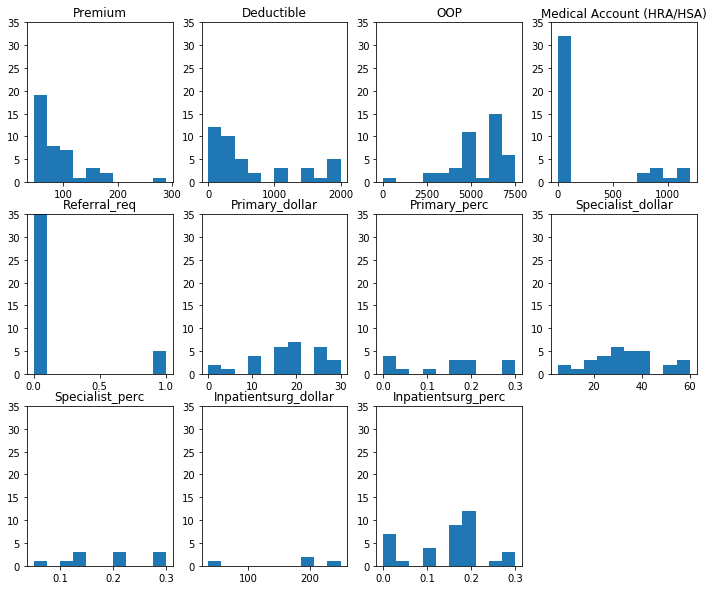

In [242]:
print('Histograms counts of each column')

plt.figure(figsize=(12,10))
for i, feature in enumerate(features[3:]):
    plt.subplot(3,4,i+1)
    counts, bins = np.histogram(df1[feature].dropna())
    plt.hist(bins[:-1], bins, weights=counts)
    plt.ylim(0,35)
    plt.title(feature)
plt.show()


2. Correlation between features

We expect that as monthly premium increases, deductible should decrease. 


Premiums vs. Deductibles: All plans--------------------------------------------------

Across all plans, as premiums increase, the deductible decreases


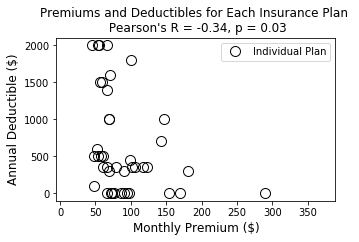

Premiums vs. Deductibles: HMOs vs. PPOs--------------------------------------------------

Both HMOs and FFSs follow the same trend as shown in all plans: as premiums increase, deductible decreases. 
However, plotting HMO and FFS plans separately shows some interesting takeaways by eye: 
For HMOs a monthly $50 premium can have a range of deductibles. And several different premiums offer a $0 deductible. 
For FFSs a monthly $50 premium can also have a range of deductibles. And several different premiums offer a $300 deductible. 
 FFSs are less likely to have $0 deductibles.


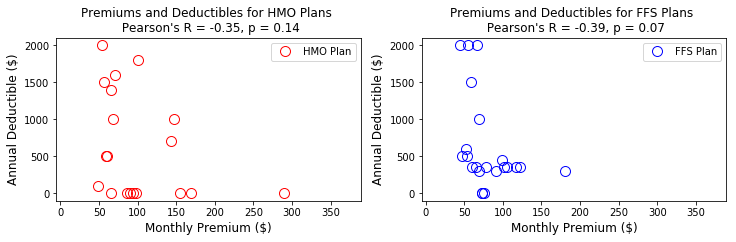

In [243]:
import scipy.stats as sstats
import seaborn as sns

fs = 10   # Set a variable for fontsize
ms = 10
current_palette = sns.color_palette("hls", 8)
xmin = df1['Premium'].min()-50
xmax = df1['Premium'].max()+100
ymin = df1['Deductible'].min()-100
ymax = df1['Deductible'].max()+100

'''
Premiums vs. Deductibles: All Plans
'''

print('Premiums vs. Deductibles: All plans' + '-'*50 + '\n')
print('Across all plans, as premiums increase, the deductible decreases')

r, p = sstats.pearsonr(df1['Premium'], df1['Deductible'])

plt.figure(figsize=(5,3))
plt.plot(df1['Premium'], df1['Deductible'], 'ko', markersize=ms, markerfacecolor='none', label='Individual Plan');
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.legend()
plt.xlabel('Monthly Premium ($)', fontsize=fs+2)
plt.ylabel('Annual Deductible ($)', fontsize=fs+2)
plt.title('Premiums and Deductibles for Each Insurance Plan \n Pearson\'s R = ' \
          + str(round(r,2)) + ', p = ' + str(round(p,2)), fontsize=fs+2)
plt.show()

#for i, txt in enumerate(df1['Code']):
#    plt.text(df1['Premium'].iloc[i], df1['Deductible'].iloc[i], str(df1['Code'].iloc[i]))

'''
Premiums vs. Deductibles: HMOs vs. PPOs
'''

print('Premiums vs. Deductibles: HMOs vs. PPOs' + '-'*50 + '\n')
print('Both HMOs and FFSs follow the same trend as shown in all plans: as premiums increase, deductible decreases. \n\
However, plotting HMO and FFS plans separately shows some interesting takeaways by eye: \n\
For HMOs a monthly $50 premium can have a range of deductibles. And several different premiums offer a $0 deductible. \n\
For FFSs a monthly $50 premium can also have a range of deductibles. And several different premiums offer a $300 deductible. \
\n FFSs are less likely to have $0 deductibles.')

r = np.empty([len(df1['Type'].unique())])
p = np.empty([len(df1['Type'].unique())])

plt.figure(figsize=(12,3))
colors = ['r','b']
for i, value_type in enumerate(df1['Type'].unique()):
    plt.subplot(1,2,i+1)
    # print(i, value_type)
    ind = df1['Type'] == value_type
    r[i], p[i] = sstats.pearsonr(df1['Premium'][ind], df1['Deductible'][ind])
    plt.plot(df1['Premium'][ind], df1['Deductible'][ind], 'o', markersize=ms, \
             markerfacecolor='none', markeredgecolor=colors[i], label=value_type + ' Plan')
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.legend()
    plt.xlabel('Monthly Premium ($)', fontsize=fs+2)
    plt.ylabel('Annual Deductible ($)', fontsize=fs+2)
    plt.title('Premiums and Deductibles for ' + value_type + ' Plans \n Pearson\'s R = ' \
              + str(round(r[i],2)) + ', p = ' + str(round(p[i],2)), fontsize=fs+2)
plt.show()

Takeaways for premium vs. deductible: 
- Across all plans, as monthly premium increases, the deductible decreases. 
- Within HMO and FFS plans, there is a preferred constant deductible (0 or 300) with varying premiums, or a preferred constant premium (~\$50\/month) with varying deductibles. 

This might mirror how people might choose their plans: based on either their monthly premium or annual deductible. 

"I can afford to pay this much per month" or "I want my deductible to be this much"

#### What about the relationship between other features? 

Those are harder to predict. 

Run correlations between each feature + plot: 

C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\lxc\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


Correlations --------------------


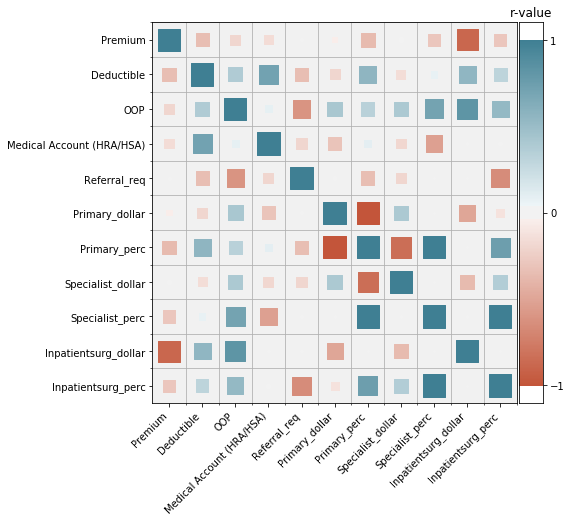

Significant Correlations (p < 0.05) --------------------


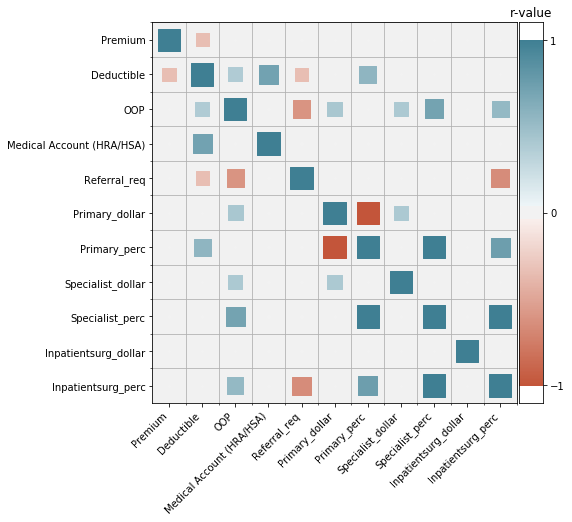

In [246]:
# Get rid of the columns Name, Type, Code - don't need to correlated these

# _np means numpy array
df1_np = copy.deepcopy(df1)
df1_np = df1_np.drop(columns=['Name', 'Type', 'Code'])

def calc_corr(df, column1, column2):
    # Input: df, column1, column2
    # Return: the correlation r, p of column1 and column2 
    df_orig = copy.deepcopy(df)
    
    # find correlation
    df = df.dropna(subset = [column1])
    df = df.dropna(subset = [column2])
    # print('Dataframe size', df.size)
    r_column, p_column = sstats.pearsonr(df[column1], df[column2])  # correlation and p_value of both values
    return r_column, p_column

features = list(df1.columns)
r = pd.DataFrame().reindex_like(corr)
p = pd.DataFrame().reindex_like(corr)
for i, f1 in enumerate(features[3:]):
    for j, f2 in enumerate(features[3:]):
        r.iloc[i,j], p.iloc[i,j] = calc_corr(df1, f1, f2)

def heatmap(x, y, **kwargs):
    """ Code from this function from:
    https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
    """
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}
    
    size_scale = 500


    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 
    plt.title('r-value')


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    plt.figure(figsize=(7,7))
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
    plt.show()

print('Correlations', '-'*20)
corrplot(r, size_scale=500, marker='s')

print('Significant Correlations (p < 0.05)', '-'*20)
r_withp = r.where(p < 0.05)
corrplot(r_withp, size_scale=500, marker='s')


Takeaways from all correlations:

- Premium is negatively correlated with deductible as we saw earlier
- Premium is positively correlated with inpatient surgery dollar copay, not as much with anything else
- OOP is positively correlated with copays across the board (doctors, specialists, surgeries). This means if your plan's OOP is high, and something happens to you, you will be paying more for those services! Sort of a catch-22. 
- Deductible is positively correlated with medical account. This makes sense: you set aside money in your medical account for your deductible. 
- Deductible correlated with OOP
- Copays (for primary care, specialist, inpatient surgeries) are **very strongly** correlated with each other. If you're paying more for one treatment, you're likely paying more for other treatments too. 



3. Heirarchical clustering of features

Based on takeaways from (2), expect some features to be clustered together.

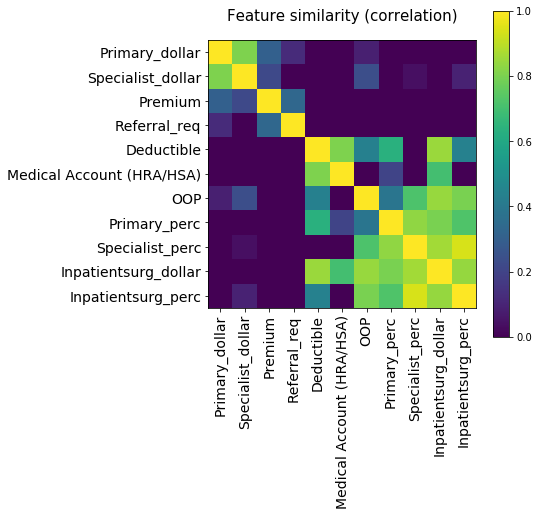

In [249]:
import scipy.cluster.hierarchy as sch
#https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb)
    
features3 = features[3:]

corrmat = r.corr().values
d = sch.distance.pdist(corrmat)
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [features3[i] for i in list(np.argsort(ind))]

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Feature similarity (correlation)', fontsize=15)
p = ax.matshow(r[columns].corr(), vmin=0, vmax=1)
ax.set_xticks(range(len(features3)))
ax.set_xticklabels(labels=columns, rotation=90, fontsize=14)
ax.xaxis.tick_bottom()
ax.set_yticks(range(len(features3)))
ax.set_yticklabels(labels=columns, fontsize=14)
fig.colorbar(p)
plt.show()

4. Detailed plots of feature relationships, separated by HMO and FFS

Maybe feature relationships are different within HMO and FFS? Plots show that they're quite similar. 


['Name', 'Type', 'Code', 'Premium', 'Deductible', 'OOP', 'Medical Account (HRA/HSA)', 'Referral_req', 'Primary_dollar', 'Primary_perc', 'Specialist_dollar', 'Specialist_perc', 'Inpatientsurg_dollar', 'Inpatientsurg_perc']
Premium vs. Deductible--------------------------------------------------

Dataframe size 574


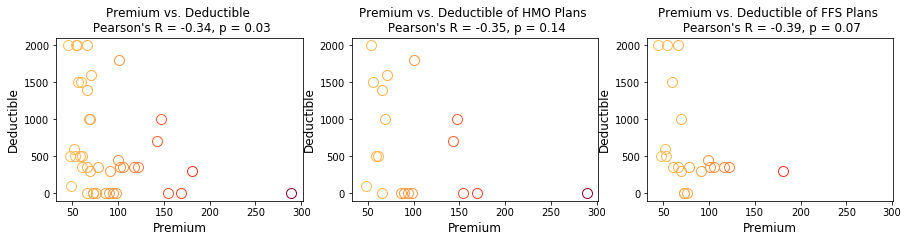

Premium vs. OOP--------------------------------------------------

Dataframe size 574


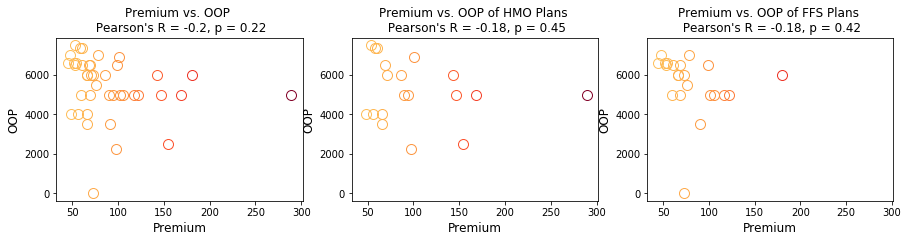

Premium vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574


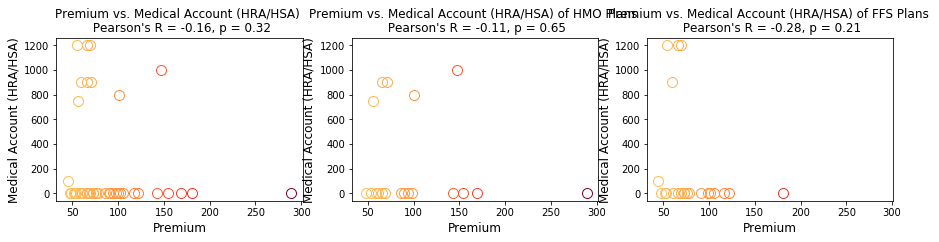

Premium vs. Referral_req--------------------------------------------------

Dataframe size 574


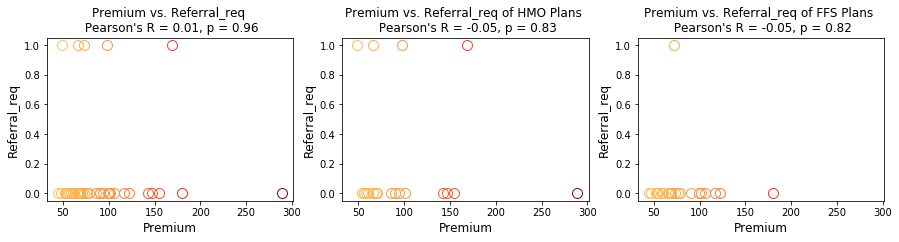

Premium vs. Primary_dollar--------------------------------------------------

Dataframe size 406


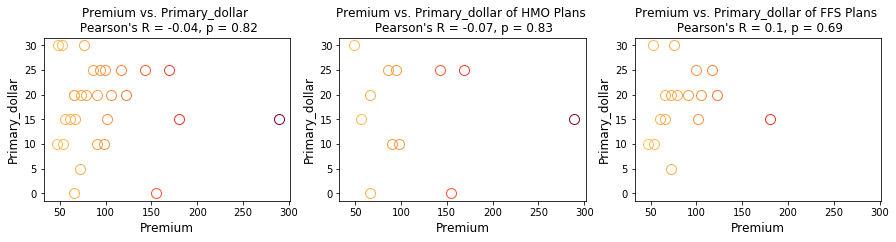

Premium vs. Primary_perc--------------------------------------------------

Dataframe size 210


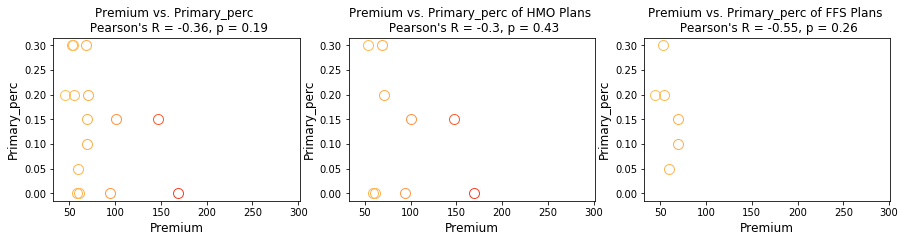

Premium vs. Specialist_dollar--------------------------------------------------

Dataframe size 434


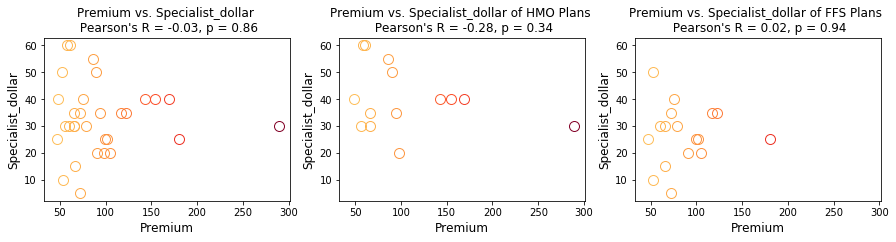

Premium vs. Specialist_perc--------------------------------------------------

Dataframe size 154


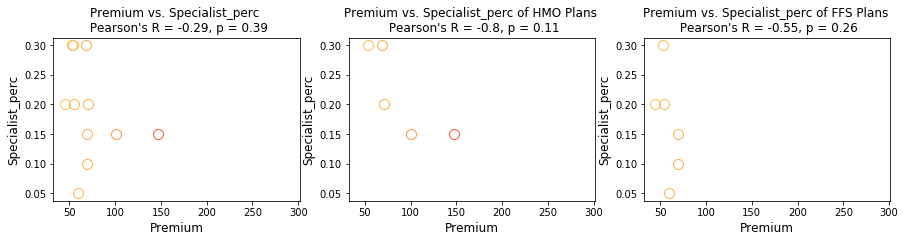

Premium vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


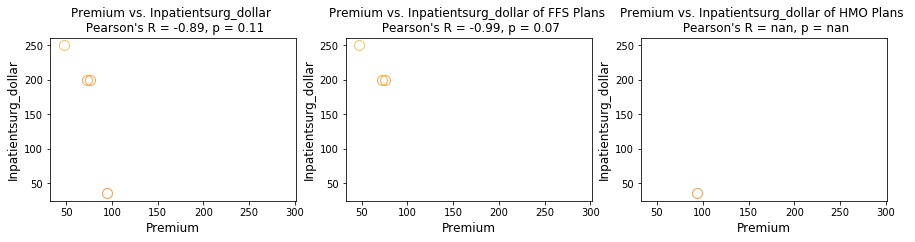

Premium vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518


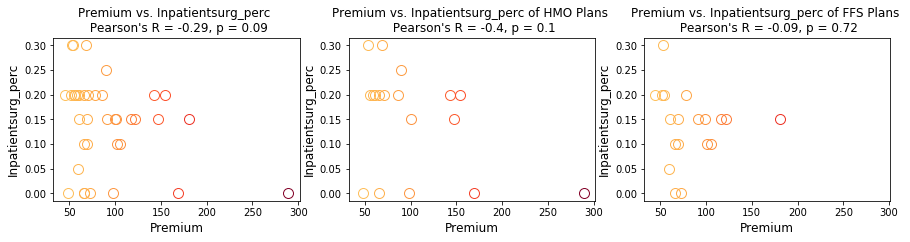

Deductible vs. OOP--------------------------------------------------

Dataframe size 574


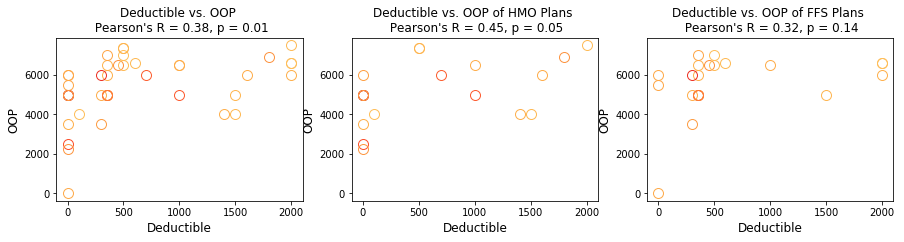

Deductible vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574


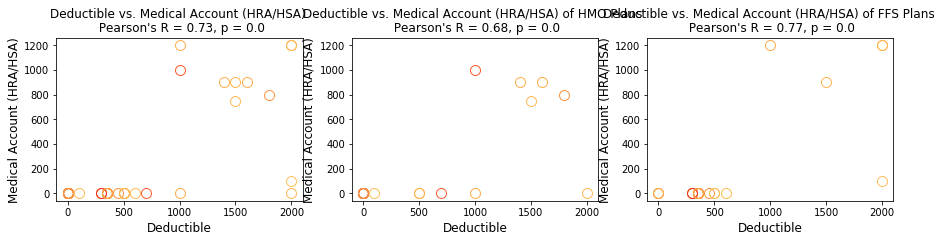

Deductible vs. Referral_req--------------------------------------------------

Dataframe size 574


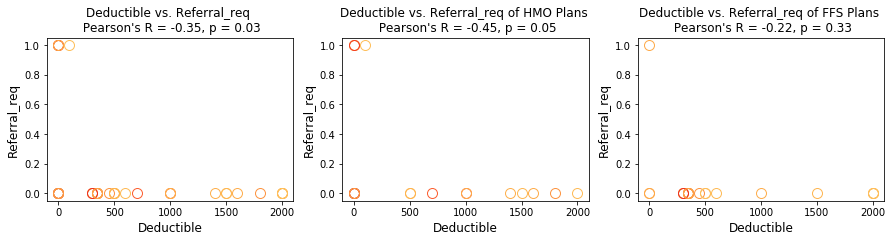

Deductible vs. Primary_dollar--------------------------------------------------

Dataframe size 406


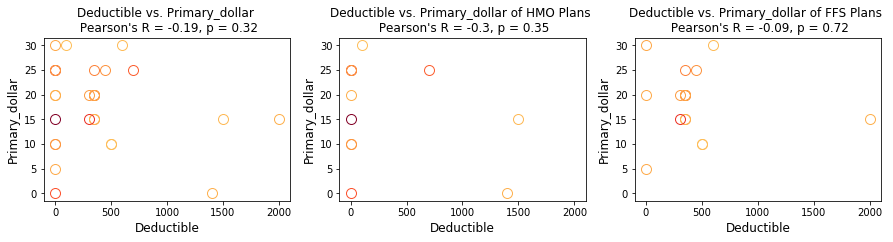

Deductible vs. Primary_perc--------------------------------------------------

Dataframe size 210


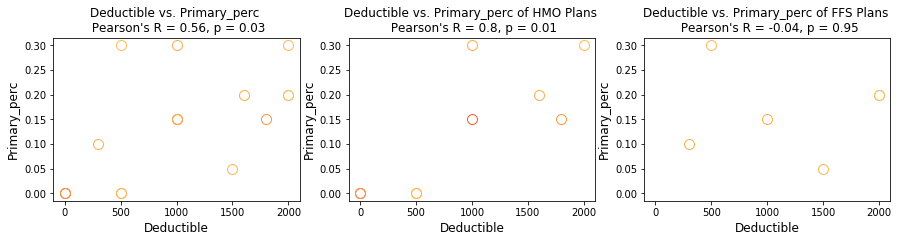

Deductible vs. Specialist_dollar--------------------------------------------------

Dataframe size 434


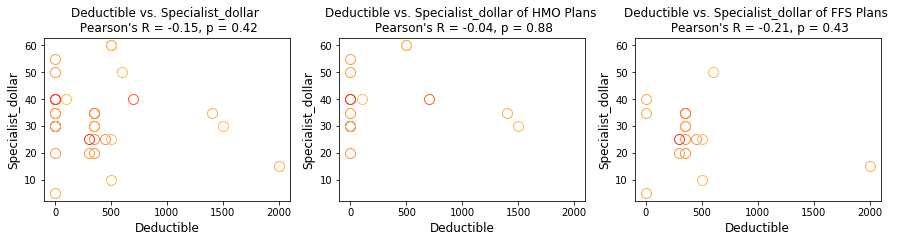

Deductible vs. Specialist_perc--------------------------------------------------

Dataframe size 154


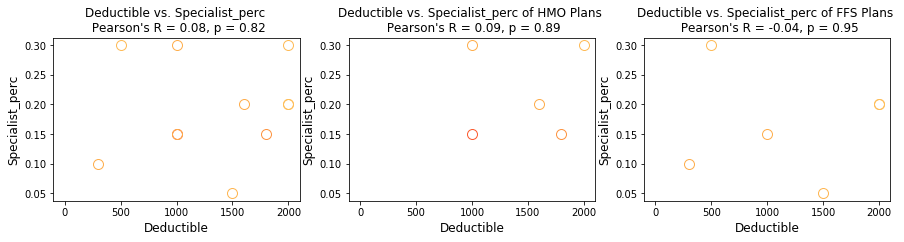

Deductible vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


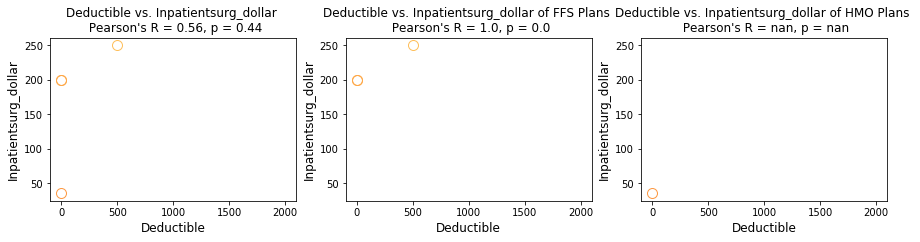

Deductible vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518


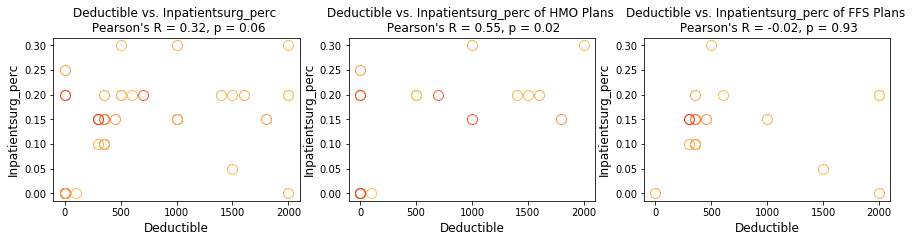

OOP vs. Medical Account (HRA/HSA)--------------------------------------------------

Dataframe size 574


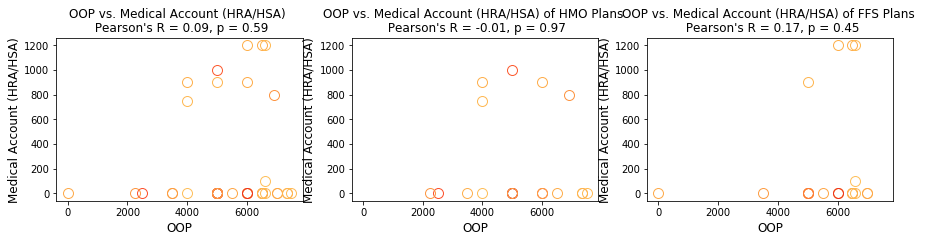

OOP vs. Referral_req--------------------------------------------------

Dataframe size 574


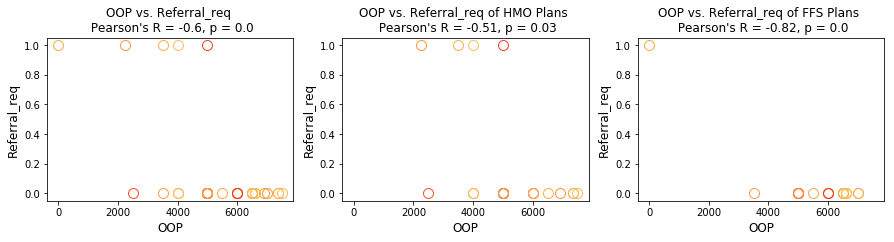

OOP vs. Primary_dollar--------------------------------------------------

Dataframe size 406


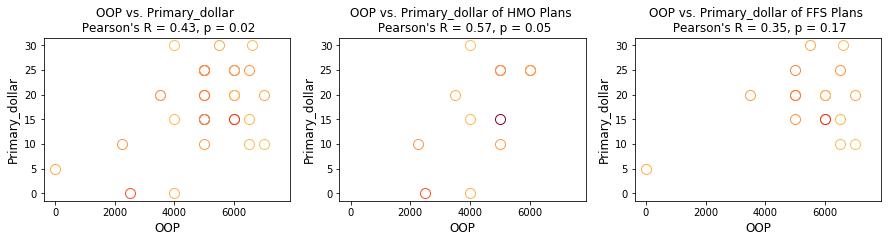

OOP vs. Primary_perc--------------------------------------------------

Dataframe size 210


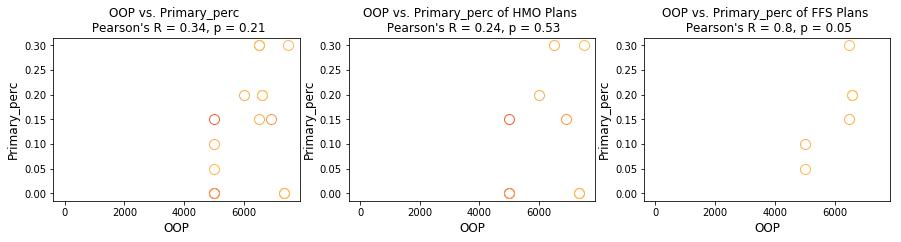

OOP vs. Specialist_dollar--------------------------------------------------

Dataframe size 434


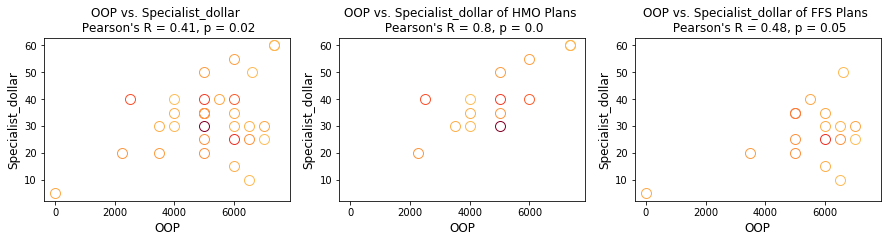

OOP vs. Specialist_perc--------------------------------------------------

Dataframe size 154


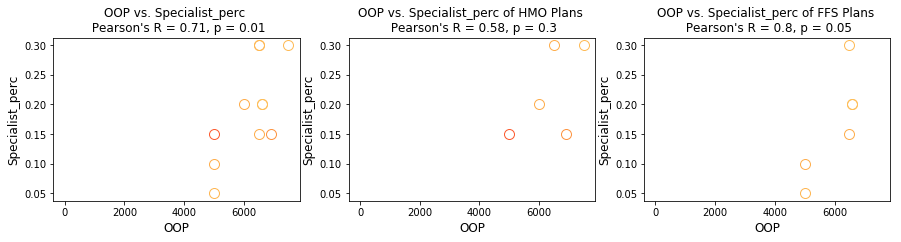

OOP vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


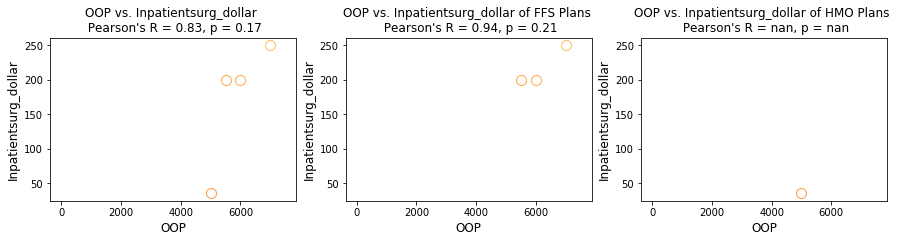

OOP vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518


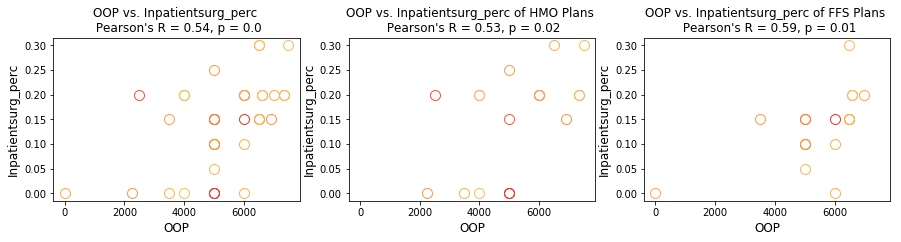

Medical Account (HRA/HSA) vs. Referral_req--------------------------------------------------

Dataframe size 574


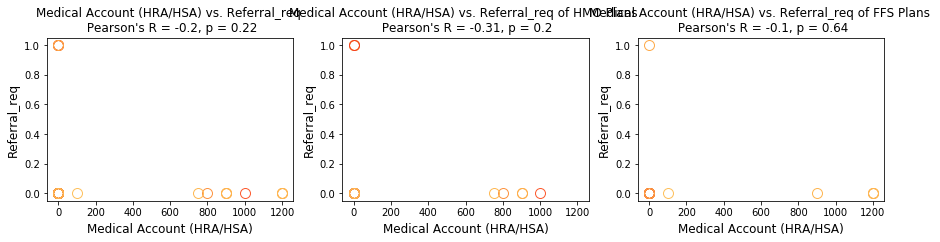

Medical Account (HRA/HSA) vs. Primary_dollar--------------------------------------------------

Dataframe size 406


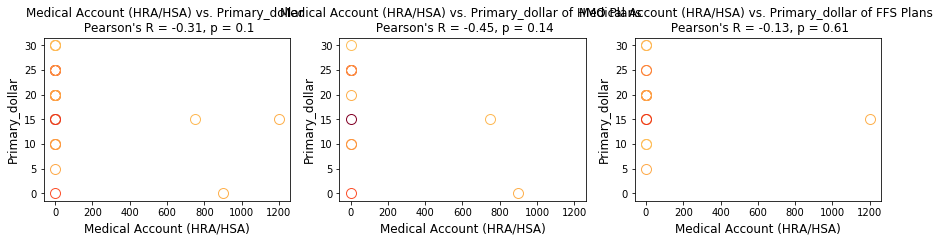

Medical Account (HRA/HSA) vs. Primary_perc--------------------------------------------------

Dataframe size 210


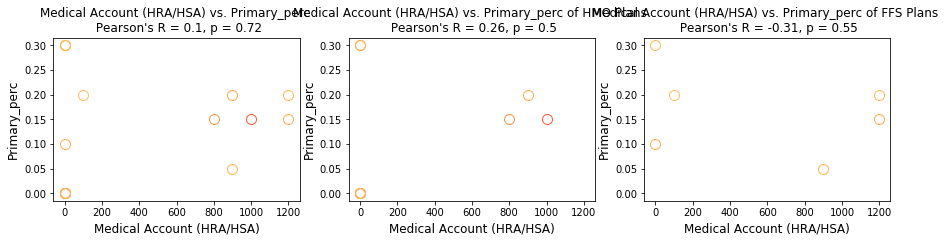

Medical Account (HRA/HSA) vs. Specialist_dollar--------------------------------------------------

Dataframe size 434


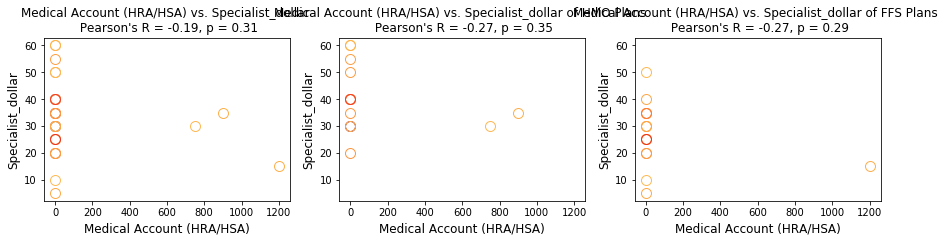

Medical Account (HRA/HSA) vs. Specialist_perc--------------------------------------------------

Dataframe size 154


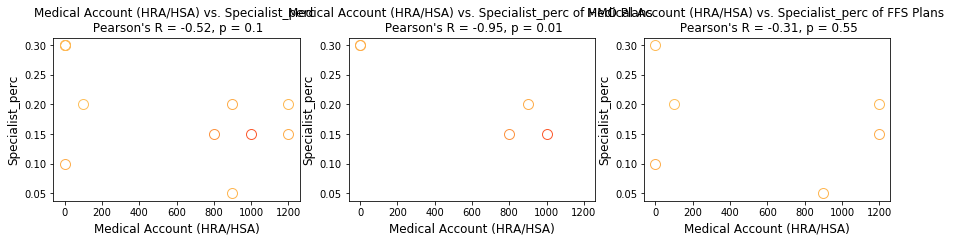

Medical Account (HRA/HSA) vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


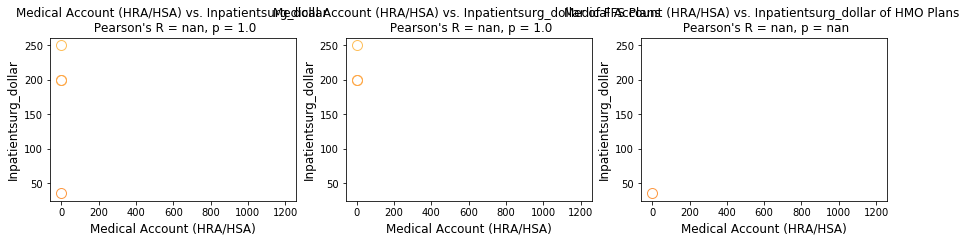

Medical Account (HRA/HSA) vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518


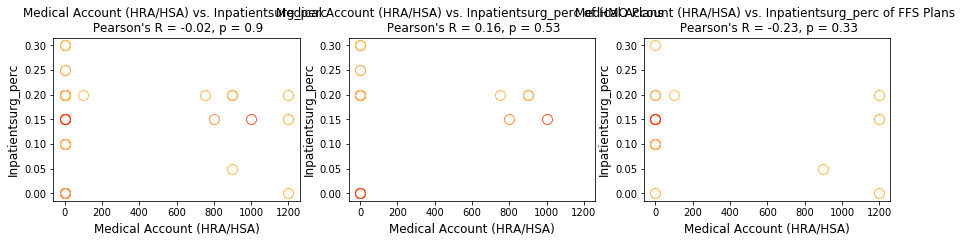

Referral_req vs. Primary_dollar--------------------------------------------------

Dataframe size 406


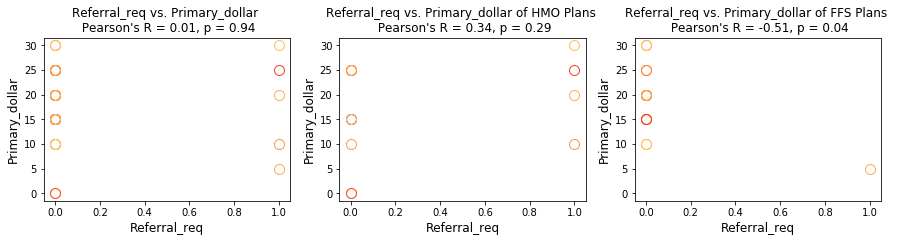

Referral_req vs. Primary_perc--------------------------------------------------

Dataframe size 210


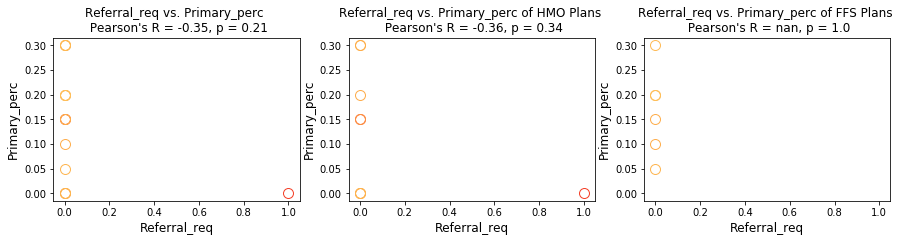

Referral_req vs. Specialist_dollar--------------------------------------------------

Dataframe size 434


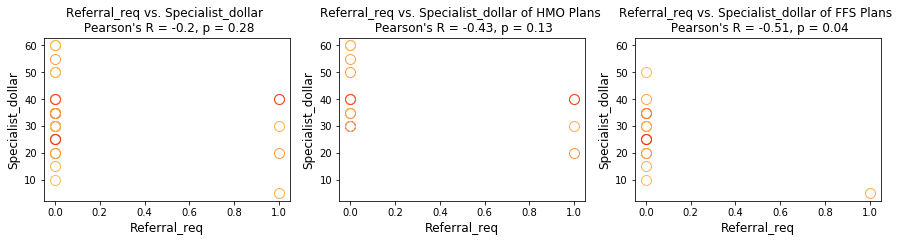

Referral_req vs. Specialist_perc--------------------------------------------------

Dataframe size 154


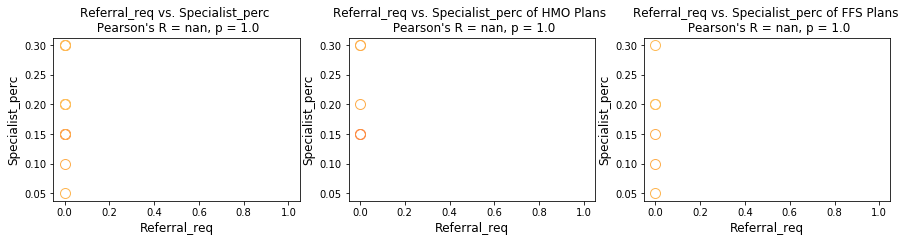

Referral_req vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


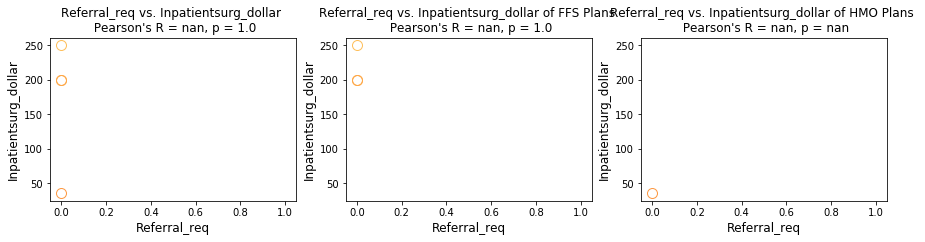

Referral_req vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 518


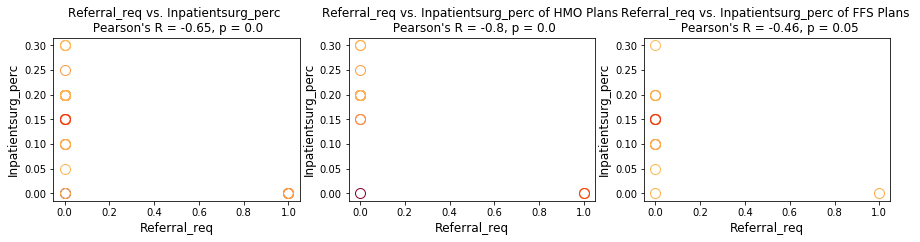

Primary_dollar vs. Primary_perc--------------------------------------------------

Dataframe size 42


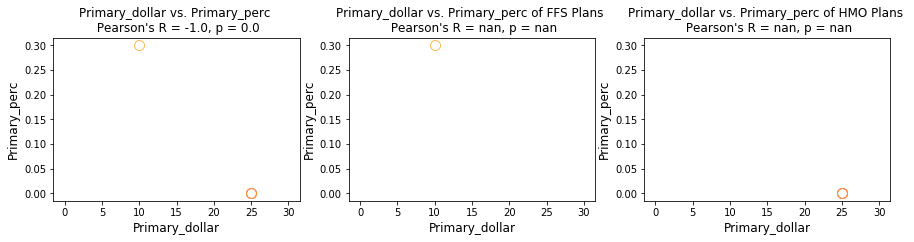

Primary_dollar vs. Specialist_dollar--------------------------------------------------

Dataframe size 406


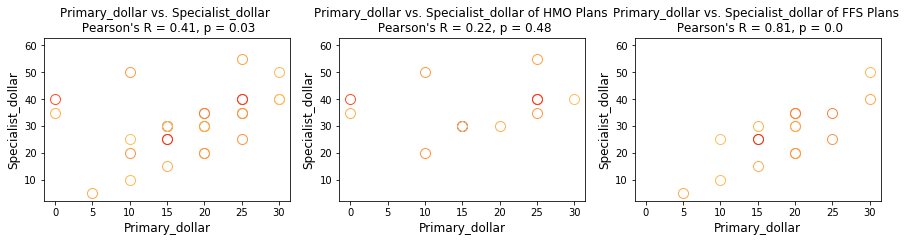

Primary_dollar vs. Specialist_perc--------------------------------------------------

Dataframe size 14


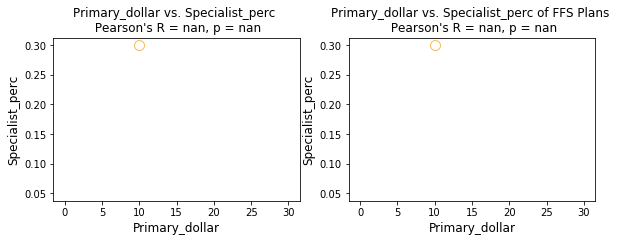

Primary_dollar vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


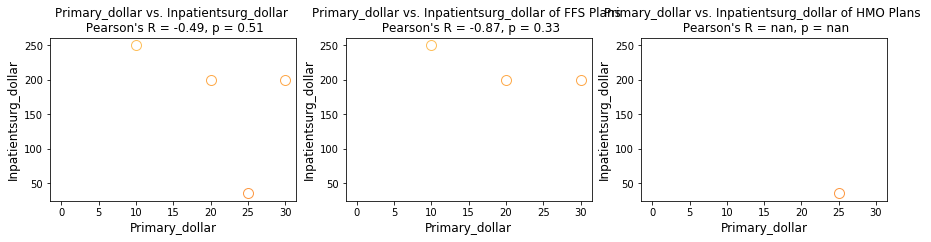

Primary_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 350


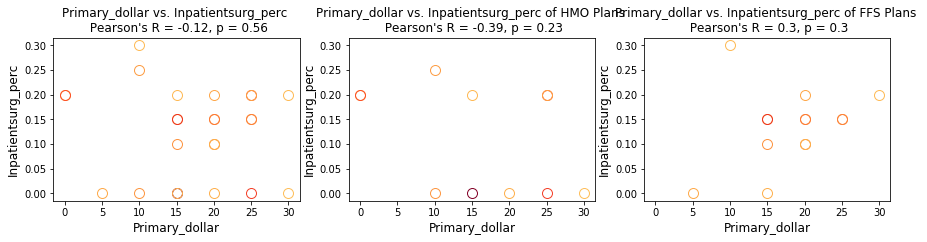

Primary_perc vs. Specialist_dollar--------------------------------------------------

Dataframe size 70


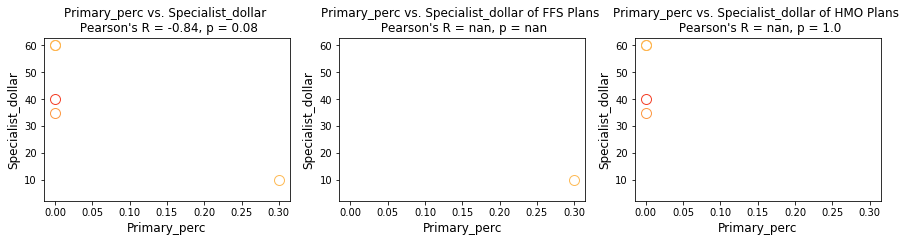

Primary_perc vs. Specialist_perc--------------------------------------------------

Dataframe size 154


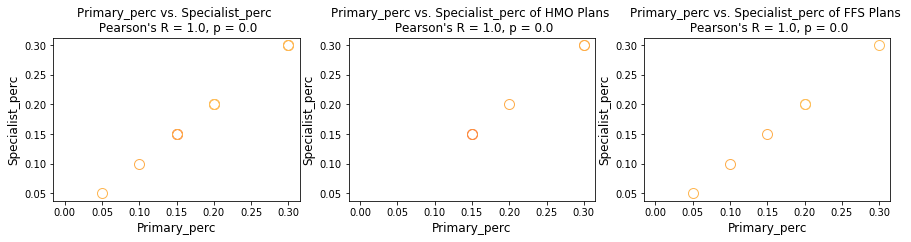

Primary_perc vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 14


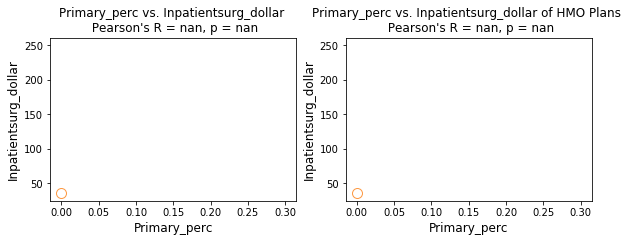

Primary_perc vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 196


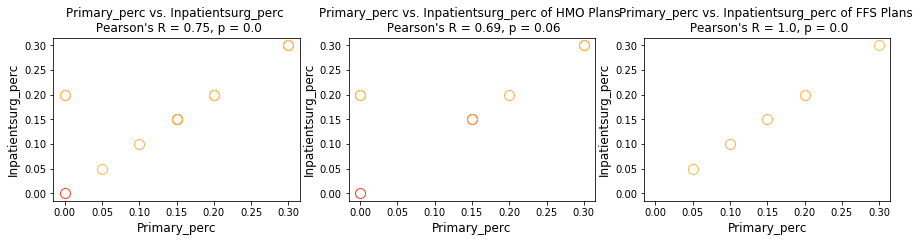

Specialist_dollar vs. Specialist_perc--------------------------------------------------

Dataframe size 14


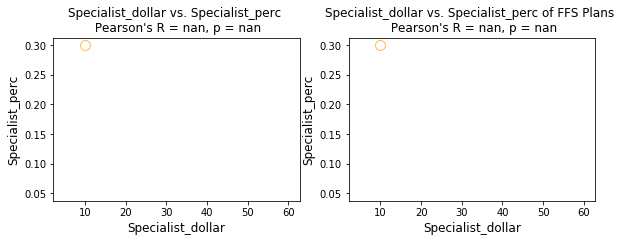

Specialist_dollar vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 56


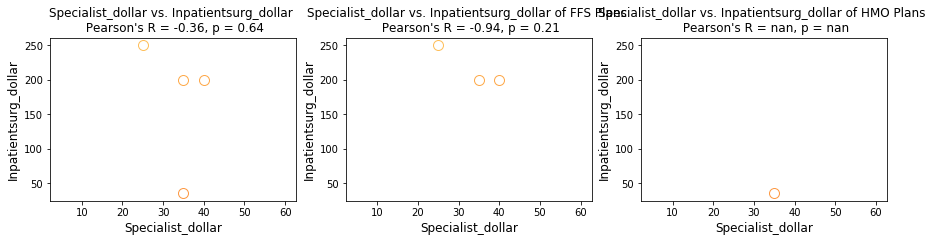

Specialist_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 378


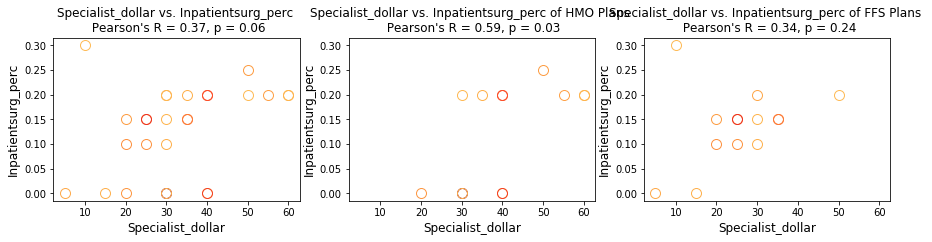

Specialist_perc vs. Inpatientsurg_dollar--------------------------------------------------

Dataframe size 0


C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\lxc\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\lxc\Anaconda\lib\site-packages\scipy\stats\stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()


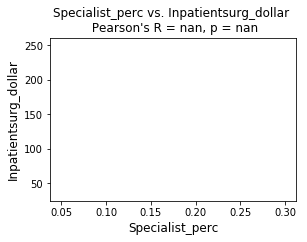

Specialist_perc vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 154


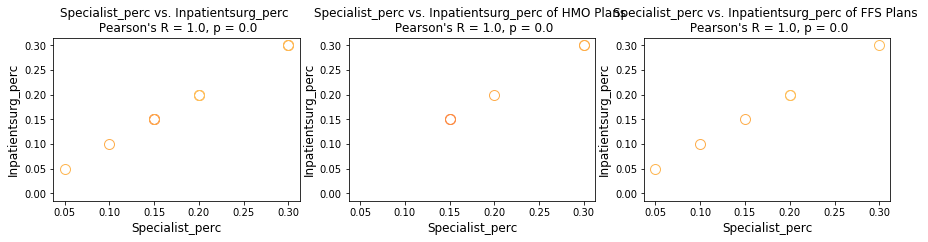

Inpatientsurg_dollar vs. Inpatientsurg_perc--------------------------------------------------

Dataframe size 0


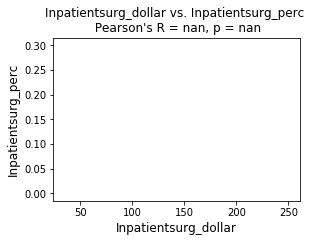

In [251]:
def plot_color(x, y, H, df):
    # x, y, color_ratio are lists or columns in a df
    current_palette = sns.color_palette("YlOrRd", 150)    # other color palettes: "CMRmap"
    current_palette = current_palette[49:]
    
    ms = 10   # Markersize
    
    x = x.reset_index(drop=True)
    y = y.reset_index(drop=True)    
    H = H.reset_index(drop=True)
    
    hmax = max(df['Premium'])   # Need to normalize premium to all premiums (not just subset)
    hmin = min(df['Premium'])
    H_diff = hmax - hmin

    for m, val in enumerate(x):
        ratio = (H[m]-hmin)/H_diff
        #print('H[m]', H[m], hmin, H_diff)
        #print('ratio', ratio)
        plt.plot(x[m], y[m], 'o', markersize=ms, markerfacecolor='none', markeredgecolor=current_palette[int(ratio*100)])

def plot_2features(df, column1, column2, column_groupby):
    # Input: df, column1, column2
    # Plot: df[column1] vs. df[column2] for HMO and FFS
    # Return: pass
    df_orig = copy.deepcopy(df)
    print(column1 + ' vs. ' + column2 + '-'*50 + '\n')
    
    current_palette = sns.color_palette("CMRmap", 150)  # Create the color palette
    fs = 10   # Set a variable for fontsize
    ms = 10
    current_palette = sns.color_palette("hls", 8)
    xmin = df[column1].min() - (df[column1].max()-df[column1].min())*0.05
    xmax = df[column1].max() + (df[column1].max()-df[column1].min())*0.05
    ymin = df[column2].min() - (df[column2].max()-df[column2].min())*0.05
    ymax = df[column2].max() + (df[column2].max()-df[column2].min())*0.05
    
    # find correlation
    df = df.dropna(subset = [column1])
    df = df.dropna(subset = [column2])
    print('Dataframe size', df.size)
    r, p = sstats.pearsonr(df[column1], df[column2])  # correlation and p_value of both values

    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    
    #plt.plot(df[column1], df[column2], 'o', label='Individual Plan');
    plot_color(df[column1], df[column2], df['Premium'], df_orig)
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    #plt.legend()
    plt.xlabel(column1, fontsize=fs+2)
    plt.ylabel(column2, fontsize=fs+2)
    plt.title(column1 + ' vs. ' + column2 + ' \n Pearson\'s R = ' \
              + str(round(r,2)) + ', p = ' + str(round(p,2)), fontsize=fs+2)

    # Plot for HMO and FFS separately
    r = np.empty([len(df[column_groupby].unique())])
    p = np.empty([len(df[column_groupby].unique())])

    #plt.figure(figsize=(12,3))
    # Find correlation and p_value grouped by column_type
    for i, value_type in enumerate(df[column_groupby].unique()):
        plt.subplot(1,3,i+2)
        #print(i, value_type)
        ind = df[column_groupby] == value_type
        
        # Find correlation
        r[i], p[i] = sstats.pearsonr(df[column1][ind], df[column2][ind])
        
        # Plot
        plot_color(df[column1][ind], df[column2][ind], df['Premium'][ind], df_orig)
        #plt.plot(df[column1][ind], df[column2][ind], 'o', markersize=ms, \
        #         markerfacecolor='none', markeredgecolor=current_palette[i], label=value_type + ' Plan')
        
        plt.xticks(fontsize=fs)
        plt.yticks(fontsize=fs)
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,ymax)
        #plt.legend()
        plt.xlabel(column1, fontsize=fs+2)
        plt.ylabel(column2, fontsize=fs+2)
        plt.title(column1 + ' vs. ' + column2 + ' of ' + value_type + ' Plans \n Pearson\'s R = ' \
                  + str(round(r[i],2)) + ', p = ' + str(round(p[i],2)), fontsize=fs+2)
    plt.show()
    return

features = list(df1.columns)
print(features)

j = 4
for f1 in features[3:]:
    for f2 in features[j:]:
        plot_2features(df1, f1, f2, 'Type')
    j=j+1



### Running PCA

Can PCA uncover HMO vs. PPO plan types? What about uncovering the plan provider?  

* Clean up data to run PCA: fill NaN values with the median of the column, z-score normalization

PCA matrix shape: (41, 11)


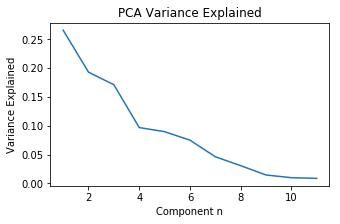

<Figure size 432x288 with 0 Axes>

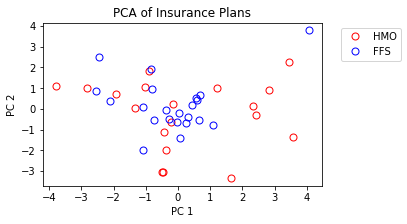

<Figure size 432x288 with 0 Axes>

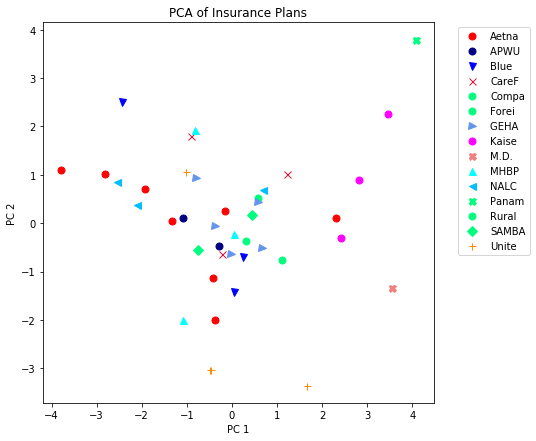

In [221]:
# PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random

''' Prepare Data
'''
# Fill NA
df1_np = df1_np.fillna(df1_np.median())

# Normalize
x = df1_np.values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
df1_train = pd.DataFrame(x_scaled)

print('PCA matrix shape:', df1_train.shape)

''' Run PCA
'''
pca = PCA(n_components=11)
pca_results = pca.fit_transform(df1_train)
x = np.arange(1,12)
plt.figure(figsize=(5,3))
plt.plot(x, pca.explained_variance_ratio_)
plt.title('PCA Variance Explained')
plt.xlabel('Component n')
plt.ylabel('Variance Explained')
plt.show()

'''Plot n=2 components of PCA by plan type (HMO vs. FFS)
'''
pca_plans = PCA(n_components=2)
pca_results = pca_plans.fit_transform(df1_train)
pca_res_df = pd.DataFrame(data = pca_results
             , columns = ['PC1', 'PC2'])
plt.figure()
plt.figure(figsize=(5,3))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("PCA of Insurance Plans")
targets = ['HMO', 'FFS']
colors = ['r', 'b']

for target, color in zip(targets,colors):   
    ind = df1['Type'] == target
    plt.plot(pca_res_df.loc[ind, 'PC1'], pca_res_df.loc[ind, 'PC2'],'o', markersize=7, \
        markerfacecolor='none', markeredgecolor=color, label=target + ' Plan')
    
plt.legend(targets,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

'''Plot n=2 components of PCA by plan name
'''
plt.figure()
plt.figure(figsize=(7,7))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("PCA of Insurance Plans")
targets = NamesList
number_of_colors = len(NamesList)
# Aetna- hmo - red
# APWU - FFS - navy
# blue - ffs - blue
# CareF - HMO - crimson
# compa - FFS (1) - springgreen
# forei - FFS (1) - springgreen
# geha - ffs - cornflowerblue
# kais - HMO - magenta
# MD - HMO (1) - lightcoral
# MHBP - FFS - cyan
# NALC - FFS - deepskyblue
# Panam - FFS (1) - springgreen
# Rural - FFS (1) - springgreen
# SAMBA - FFS (1) - springgreen
# united - HMO - darkorange
colors = ['red', 'navy', 'blue', 'crimson', 
         'springgreen', 'springgreen', 
         'cornflowerblue', 'magenta', 'lightcoral',
         'cyan', 'deepskyblue', 
         'springgreen', 'springgreen', 'springgreen',
         'darkorange']
markers = ['o', 'o', 'v', 'x',
          'o', 'o',
          '>', 'o', 'X',
         '^', '<',
         'X','o','D',
         '+']

for target, color, marker1 in zip(targets,colors, markers):  
    ind = df1['Name'] == target
    plt.plot(pca_res_df.loc[ind, 'PC1'], pca_res_df.loc[ind, 'PC2'],marker=marker1, 
             linestyle='', markersize=7, \
        markerfacecolor=color, markeredgecolor=color, label=target + ' Plan')
    
plt.legend(targets,bbox_to_anchor=(1.05, 1), loc='upper left')


Takeaways: 

- Some non-linear clustering by plan type: FFS is more in the center while HMOs are around the border
- Some specific providers tend to have their own cluster within PC1 and PC2
- 5 PCs necessary to get 85% variance

Recommendation: 
- Check out some providers in HMO or FFS and see which you prefer
- Unless one has a lot of medical needs, go with the lowest premium. For that premium, compare which plan has the lowest deductible and OOP max. Next look at the copays to see if they're reasonable. If it works, then it's probably a good plan. 


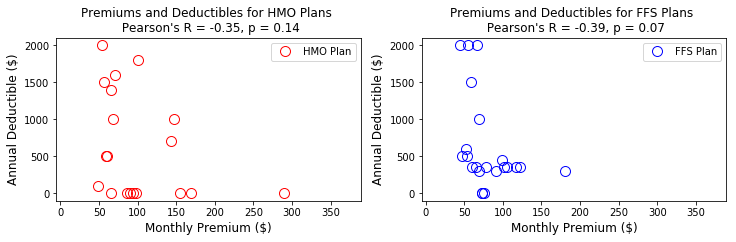

In [258]:
'''
Premiums vs. Deductibles: HMOs vs. PPOs
'''
r = np.empty([len(df1['Type'].unique())])
p = np.empty([len(df1['Type'].unique())])

plt.figure(figsize=(12,3))
colors = ['r','b']
for i, value_type in enumerate(df1['Type'].unique()):
    plt.subplot(1,2,i+1)
    # print(i, value_type)
    ind = df1['Type'] == value_type
    r[i], p[i] = sstats.pearsonr(df1['Premium'][ind], df1['Deductible'][ind])
    plt.plot(df1['Premium'][ind], df1['Deductible'][ind], 'o', markersize=ms, \
             markerfacecolor='none', markeredgecolor=colors[i], label=value_type + ' Plan')
    
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.legend()
    plt.xlabel('Monthly Premium ($)', fontsize=fs+2)
    plt.ylabel('Annual Deductible ($)', fontsize=fs+2)
    plt.title('Premiums and Deductibles for ' + value_type + ' Plans \n Pearson\'s R = ' \
              + str(round(r[i],2)) + ', p = ' + str(round(p[i],2)), fontsize=fs+2)
plt.show()

Next steps: 
- Incorporate Rx coverage. Expect Rx to positively correlate with copays. 

Additional stuff / WIP

* Linear regression to predict premium from features

Probably similar results as PCA: 
* kmeans
* t-sne

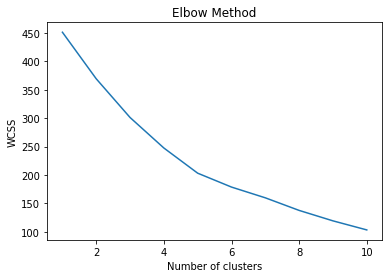

In [255]:
# Kmeans

from sklearn.cluster import KMeans
#https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
%matplotlib inline

Kmean = KMeans(n_clusters=2)
Kmean.fit(df1_train)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df1_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


t-sne

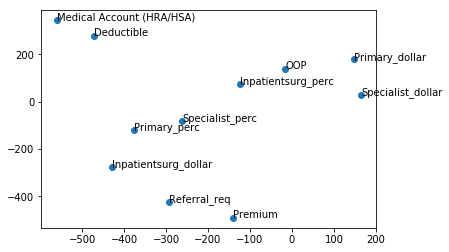

In [254]:
from sklearn.manifold import TSNE
X = df1_train.T
X_embedded = TSNE(n_components=2, perplexity=3, init='pca').fit_transform(X)

plt.scatter(X_embedded[:,0], X_embedded[:,1])
for i, feature in enumerate(features3):
    plt.annotate(feature, (X_embedded[i,0], X_embedded[i,1]))